***
<center><h1>Face Rhythm</h1></center>

***

<center> <table> <tr>
 
<td> <img src="https://images.squarespace-cdn.com/content/5688a31305f8e23aa2893502/1614723283221-5Z5038AT7Y6KCOM2PIU4/Screenshot+from+2021-03-02+17-05-12.png?content-type=image%2Fpng" style="height: 100px"> </td>
<td> <img src="https://images.squarespace-cdn.com/content/5688a31305f8e23aa2893502/1614723856628-J89PYYSF7K7JATE2KMF9/Screenshot+from+2021-03-02+17-23-46.png?format=300w&content-type=image%2Fpng" style="height: 100px"> </td>
<td> <img src="https://images.squarespace-cdn.com/content/5688a31305f8e23aa2893502/1614723931026-OORV0RAPZNWV3R8TBOXB/Screenshot+from+2021-03-02+17-25-11.png?format=300w&content-type=image%2Fpng" style="height: 100px"> </td>
<td> <img src="https://images.squarespace-cdn.com/content/5688a31305f8e23aa2893502/1614724055033-O3GBEF1D9MULFZKI2IUJ/Screenshot+from+2021-03-02+17-27-10.png?format=300w&content-type=image%2Fpng" style="height: 100px"> </td>

</tr> </table></center>

***

##### Notebook Shortcuts
- **[Notebook Setup](#Notebook-Setup)**: Prepare all the necessary config files and folders
- **[Set ROI](#Set-ROI)**: Set the ROI for the analysis
- **[Run Optic Flow](#Run-Optic-Flow)**: Run the optic flow analysis
- **[Clean Optic Flow](#Clean-Optic-Flow)**: Optic flow post-processing
- **[Convolutional Dimensionality Reduction](#Convolutional-Dimensionality-Reduction)**: Convolutional Dimensionality Reduction
- **[Analysis](#Analysis)**: Decompose and Analyze the optic flow data in many ways

***

# Tips on running this notebook:
In theory it would be nice if you could just enter the path of the video(s) and just let it run all the way through. In practice, there are a few hoops to jump through
- Run the Notebook Setup Block (two blocks below this one). This should pretty much always be done, even if you are loading precomputed file from disk instead of calculating them. This step loads in some useful meta data used throughout.
- Even if you are restarting at a specific point in your analysis, run your Setup Block then head down to your current analysis step cell 

***
<center><h1>Notebook Setup</h1></center>

***

### Creates config and locates videos

**Crucially, always run this first cell every time you run this notebook.**

Also, generally make sure to read through the config parameters before running.

The Project path is the path to a folder (existing or not) where we will store our derived files. I recommend creating a project folder and then copying this notebook into that folder.
The Video path is the path to a folder containing videos. 
The run name will determine the name of the config. You might create multiple configs if you want to re-run the same data with slightly different parameters

Previous face rhythm users might be familiar with the 'sessions' structure. Some users will want to run multiple sessions through Face Rhythm at the same time. If that's you, then read the docs to see what parameters to change:
https://face-rhythm.readthedocs.io/

If you did everything according to the readme, you should see that the video_path currently points to a folder containing one sample video in the testing folder. Give this a try!

In [2]:
# ALWAYS RUN THIS CELL
# widen jupyter notebook window
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

from face_rhythm.util import helpers, setup
from pathlib import Path

# General Parameters
overwrite_config = False
remote           = False # Select true if running on any system where your kernel isn't on your local machine
trials           = False # Let us know if you're using trials and want to use them as a dimension in the factorization
multisession     = False # Set to true if you're doing a multisession analysis

# Project path, video path, and (optionally) run name
project_path     = Path(r'/media/rich/bigSSD/analysis_data/mouse 2_6/20210417/FR_run1_vqt').resolve() # often Path.cwd().resolve() is useful
video_path       = Path(r'/media/rich/bigSSD/res2p/Camera data/round 5 experiments/mouse 2_6/20210417/cam3/experiment').resolve() 
run_name         = 'run1'

config_filepath = setup.setup_project(project_path, video_path, run_name, overwrite_config, remote, trials, multisession)

OpenCV version: 4.5.2
Pytorch version: 1.7.1+cu110


In [2]:
from face_rhythm.util import helpers, setup
# IMPORT VIDEOS
# See the docs for more information on video path setting
# https://face-rhythm.readthedocs.io/

config = helpers.load_config(config_filepath)
config['Video']['file_prefix'] = 'cam3' # change this to 'session_prefix' if multisession
config['Video']['print_filenames'] = True
config['General']['overwrite_nwbs'] = False
helpers.save_config(config, config_filepath)

setup.prepare_videos(config_filepath)

{'name': 'session', 'videos': ['/media/rich/bigSSD RH/res2p/Camera data/round 5 experiments/mouse 2_6/20210417/cam3/experiment/cam32021-04-18T00_41_02.avi']}
Current Session: session
number of videos: 1
number of frames per video (roughly): 436601
number of frames in ALL videos (roughly): 436601

 ['/media/rich/bigSSD RH/res2p/Camera data/round 5 experiments/mouse 2_6/20210417/cam3/experiment/cam32021-04-18T00_41_02.avi']
Sampling rate pulled from video file metadata:   120.0 frames per second
nwb for session already exists, not overwriting
set config["General"]["overwrite_nwbs"]=True for otherwise


***
<center><h1>Set ROI</h1></center>

***

### Manually specify your roi

This is good if your animal doesn't fill the view and if you have stationary objects nearby.

<IPython.core.display.Javascript object>


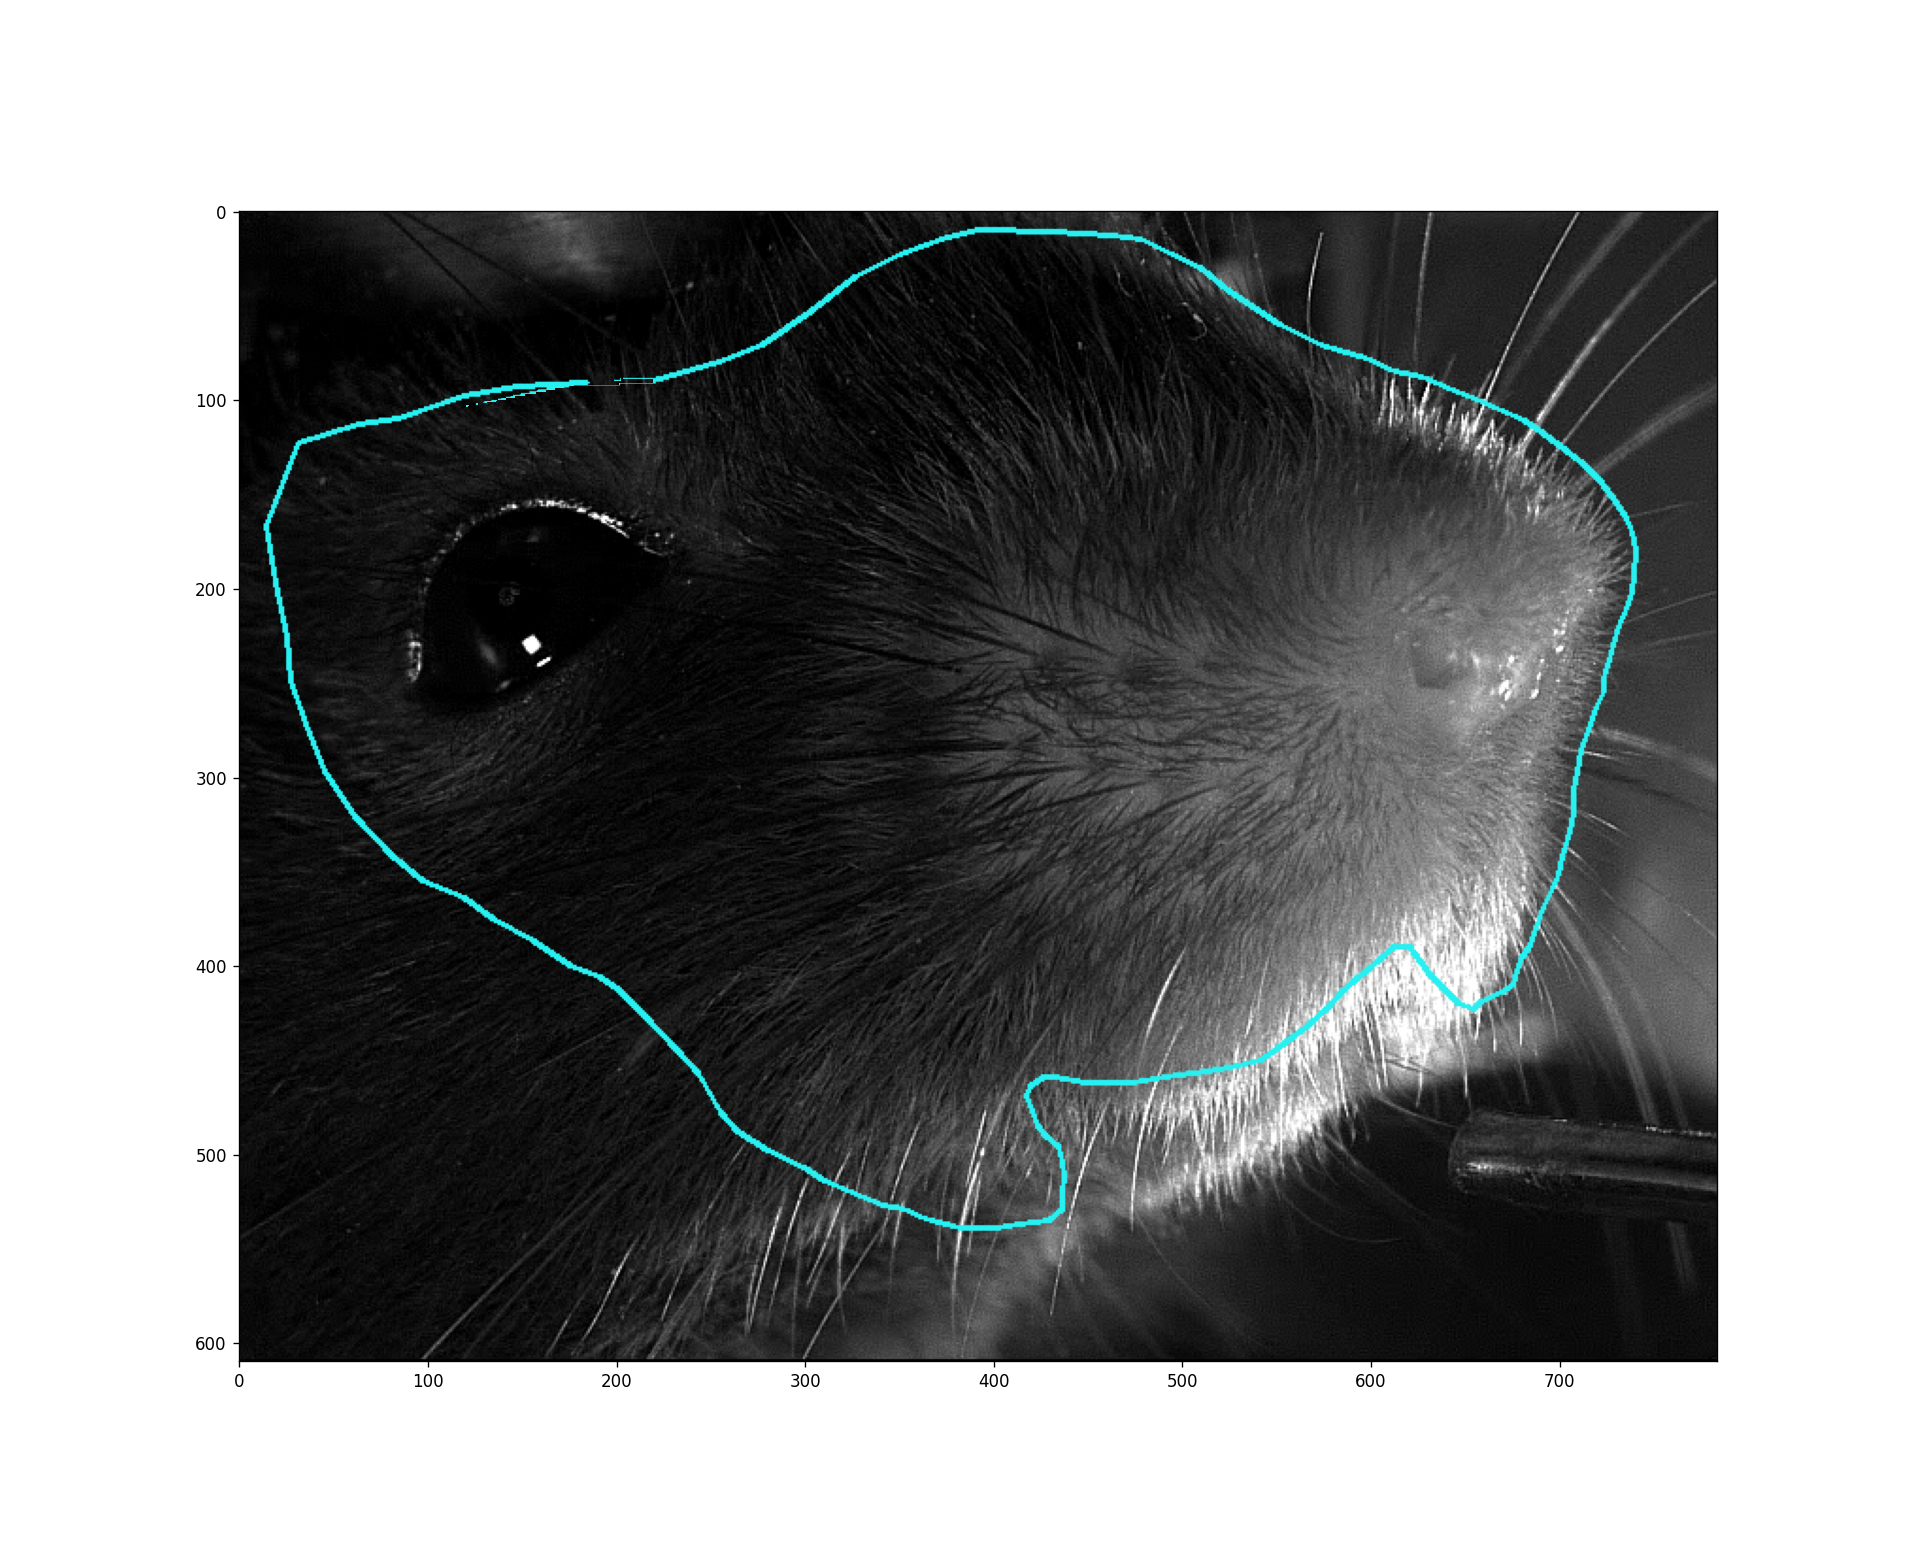

Button(description='Confirm ROI', style=ButtonStyle())

In [4]:
%matplotlib notebook

from face_rhythm.util import helpers, set_roi

# Select Bounding ROI for this analysis
# This block of code will pop up a little GUI. Click around the
# region of the face that you want to include in the analysis.
# When you are done, click the 'Confirm ROI' button

config = helpers.load_config(config_filepath)
config['ROI']['session_to_set'] = 0 # 0 indexed. Chooses the session to use
config['ROI']['vid_to_set'] = 0 # 0 indexed. Sets the video to use to make an image
config['ROI']['frame_to_set'] = 1 # 0 indexed. Sets the frame number to use to make an image
config['ROI']['load_from_file'] = False # if you've already run this and want to use the existing ROI, set to True
helpers.save_config(config, config_filepath)

frame, bbox_selector = set_roi.get_roi(config_filepath)

In [5]:
# Don't run this until you're done selecting
if not config['ROI']['load_from_file']:
    set_roi.process_roi(config_filepath, frame, bbox_selector)

Saving bbox_subframe_displacement in Group Original Points
Saving pts_displacement in Group Original Points
Saving pts_x_displacement in Group Original Points
Saving pts_y_displacement in Group Original Points
Saving mask_frame_displacement in Group Original Points


***
<center><h1>Run Optic Flow</h1></center>

***

# Optic flow calculation

Multithread is generally 2X to many-X faster, but may fail when too many dots are selected (memory overload)

*If show video set to true on a remote connection, the video won't show, but it will save to the proj folder.*

Key Optic flow params:
- **'spacing'**: ~ 3 to 12. Spacing between dots, in pixels. Inversely related to number of dots to use in the calculation. Try to keep the number of dots below 2000 if possible (eats up memory and computation time). More dots generally means better final results, more robust to outliers and weird stuff. I'd make the spacing as small (more dots) as you can go before you run out of RAM in the final calculations
- **lk_params 'win_size'**: ~ 25,25 to 80,80. This is the spatial integration window for the optical flow measurement. Try to make it as small as possible without it becoming unstable. The two values are for X and Y length of square integration window. Probably keep the same for most applications
- **multithread**: There are two ways to run optic flow: one single-threaded and one multi-threaded. Do parameter tuning on the single-threaded one so you can quit out of it, as well as watch the calculation as it happens with showVideo_pref=True. The multi-threaded one is only faster if you have a lot of cores in your CPU (>10), then it's faster, else stick with the single-threaded version and set showVideo_pref=False.

In [7]:
from face_rhythm.optic_flow import optic_flow
import cv2


config = helpers.load_config(config_filepath)

config['Optic']['vidNums_toUse'] = list(range(config['General']['sessions'][0]['num_vids'])) ## 0 indexing. Use this line of code to run all the videos in a particular session

# Parameters for lucas kanade optical flow
# win size: spatial integration window (make small as possible, but make bigger if youre having issues with outliers)
# max level: only moderate effects if everything working properly. Keep around 3.
# criteria values have to do with the search algorithm. For speed: EPS small, COUNT big (if data is gud)
config['Optic']['spacing'] = 8 ## This is the distance between points in the grid (both in x and y dims)
config['Optic']['lk'] = {}
config['Optic']['lk']['winSize']     = (60,60)
config['Optic']['lk']['maxLevel']    = 10
config['Optic']['lk']['criteria']    = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 1, 0.0001)


config['Optic']['showVideo_pref'] = False ## much faster when video is off. If 'remote' option chosen (from first cell block), video will be saved as file in project folder.
config['Video']['dot_size'] = 1  ## for viewing purposes
config['Video']['save_demo'] = False # Whether to save the demo video (true for remote users when showvideo is true)
config['Video']['demo_len'] = 10 # used when remote users when show_video==True
config['Video']['fps_counterPeriod'] = 10 # number of frames between fps averaging calculation
config['Video']['printFPS_pref'] = False # option for whether fps should be printed in notebook

config['Optic']['recursive'] = True
config['Optic']['recursive_relaxation_factor'] = 0.005
config['Optic']['multithread'] = False # Must be False if 'recursive'==True  OR  if 'showVideo_pref'==True

helpers.save_config(config, config_filepath)


### == CALCULATION ==

optic_flow.optic_workflow(config_filepath)

== Beginning optic flow computation ==
number of points: 3960
Optic Flow Set Up. Elapsed time: 31.57 seconds

 Calculating displacement field: video # 1/1



video time elapsed:. Elapsed time: 2.37 hours
Capture rate: 51.11 fps
Displacements computed. Elapsed time: 2.4 hours
Saving displacements in Group Optic Flow
Saving positions_recursive in Group Optic Flow
Saving color_tuples in Group Optic Flow
Saving pointInds_toUse in Group Optic Flow
Session session completed. Elapsed time: 2.51 hours
Total number of frames: 436601 frames
Average frames per second: 48.31 fps
total elapsed time. Elapsed time: 2.51 hours
== End Optic Flow Computation ==


***
<center><h1>Clean Optic Flow</h1></center>

***

### Clean up displacements traces and make good positions traces

Key Outlier removal params:
- **outlier_threshold_positions**: ~ 20 to 100. If a dot strays more than this many pixels away from its anchor position, its displacement in the dimension it cross the threshold in, for those time points (and some time points around it, see params below), for that dot only, will be set to zero
- **outlier_threshold_displacements** ~ 5 to 25. Similar to above, but for displacement. Only the outlier time points are removed (no window around outliers considered).
- **framesHalted_beforeOutlier**: ~ 0 to 30. The number of frames to also remove before detected outlier events. Consider what is causing your outlier event. If it is an arm movement or something, how long does such a movement last? How long before it will cause a dot to move to the outlier threshold?
- **framesHalted_afterOutlier**: ~ 0 to 10. Simlar to above but for after an outlier event is detected
- **relaxation_factor** : ~ 0.03 to 0.1. This is the rate of the exponential decay / relaxation / attraction back to the anchor position that a point undergoes. It is meant to prevent baseline drift. Think of it like a high pass on the dot position trace

In [8]:
from face_rhythm.optic_flow import clean_results

## Create position trace from displacements
## This block does a few things:

## 1. Finds outliers: These are currently defined as time points when the integrated position goes beyond some threshold.
##  Note that since displacements are calculated for x and y separately, outlier events are also separated into x outlier events
##  and y outlier events.

## 2. Sets displacements during outlier events to ZERO: There are some parameters below that define the time window (in frames)
##  before and after outliers to also set to zero. Note again, that DISPLACEMENT (the derivative of position) is set to zero, 
##  effectively pausing the position of the ingegrated position.

## 3. Rectifies the position to its 'anchor position': I am defining position as the integrated displacement arising from a STATIC
##  place in the image. Because this analysis is image agnostic, drift naturally occurs. This term counteracts drift by simply
##  relaxing each dot's position back to the center of its displacement analysis window. This term should be as low as possible
##  because it also acts as a high pass filter, thus precluding analysis of slow timescale changes.

## Note that using a standard frequency filter (fir, iir) here for the rectification / relaxation doesn't work well

config = helpers.load_config(config_filepath)
config['Clean']['outlier_threshold_positions'] = 150 ## in pixels. If position goes past this, short time window before and including outlier timepoint has displacement set to 0 
config['Clean']['outlier_threshold_displacements'] = 15 ## in pixels. If displacement goes past this, displacement set to 0 at those time points
config['Clean']['framesHalted_beforeOutlier'] = 15 # in frames. best to make even
config['Clean']['framesHalted_afterOutlier'] = 5 # in frames. best to make even
config['Clean']['relaxation_factor'] = 0.0035 # This is the speed at which the integrated position exponentially relaxes back to its anchored position. Make ~0.005 to 0.05 for face video at 120 Hz
helpers.save_config(config, config_filepath)

clean_results.clean_workflow(config_filepath)

== Beginning outlier removal ==
Saving positions_cleanup in Group Optic Flow
Saving positions_cleanup_absolute in Group Optic Flow
Session session completed. Elapsed time: 10.67 minutes
total elapsed time. Elapsed time: 10.69 minutes
== End outlier removal ==


In [ ]:
# Display the new points!
from face_rhythm.visualize import videos

config = helpers.load_config(config_filepath)
config['Video']['demo_len'] = 100
config['Video']['data_to_display'] = 'positions_cleanup_absolute'
config['Video']['save_demo'] = True 
helpers.save_config(config, config_filepath)

videos.visualize_points(config_filepath)

***
<center><h1>Convolutional Dimensionality Reduction</h1></center>

***

### Do some denoising and to get the number of dots down to a managable number

In particular, it is nice for the batched CP decomposition later that the batches can be as big as possible in the temporal dimension, so doing some mild convolutional dim reduction first is helpful.

In [9]:
%matplotlib inline

from face_rhythm.optic_flow import conv_dim_reduce

config = helpers.load_config(config_filepath)

# Create kernel
config['CDR']['width_cosKernel'] = 25 # This is the RADIUS of a 2-dimensional cosine kernel. If you get an error about SVD not working, probably increase this
config['CDR']['num_dots'] = config['Optic']['num_dots']

# Distance between points in the grid, longer than optic 
config['CDR']['spacing'] = 13

# For displaying dots
config['CDR']['display_points'] = False # checkout the dots and overlayed filter
config['CDR']['vidNum'] = 0 # 0 indexed
config['CDR']['frameNum'] = 1 # 0 indexed
config['CDR']['dot_size'] = 1
config['CDR']['kernel_alpha'] = 0.3
config['CDR']['kernel_pixel'] = 10

# Coefficients of influence 
config['CDR']['num_components'] = 2
helpers.save_config(config, config_filepath)

conv_dim_reduce.conv_dim_reduce_workflow(config_filepath)

== Beginning convolutional dimensionality reduction ==



Kernel created. Elapsed time: 2.44 minutes
number of points: 1498
Points spaced out. Elapsed time: 0.12 seconds



Saving positions_convDR_meanSub in Group Optic Flow
Saving positions_convDR_absolute in Group Optic Flow
Saving pts_spaced_convDR in Group Optic Flow
Session session completed. Elapsed time: 1.29 hours
total elapsed time. Elapsed time: 1.33 hours
== End convolutional dimensionality reduction ==


In [16]:
# Display the new points!

from face_rhythm.visualize import videos

config = helpers.load_config(config_filepath)
config['Video']['demo_len'] = 120*300
config['Video']['data_to_display'] = 'positions_convDR_absolute'
config['Video']['save_demo'] = True 
helpers.save_config(config, config_filepath)

videos.visualize_points(config_filepath)

saving to file /media/rich/bigSSD RH/analysis_data/mouse 2_6/20210417/FR_run1/viz/demos/session_positions_convDR_absolute_demo.avi


KeyboardInterrupt: 

***
<center><h1>Analysis</h1></center>

***

### Decompose and Analyze the Data in different ways

Below you'll find the following:
- PCA done on the point positions
- TCA done on the point positions
- Spectral analysis of every pixel to transoform the basis to be oscillatory
- TCA done on the spectra

### PCA

In [ ]:
from face_rhythm.analysis import pca

pca.pca_workflow(config_filepath, 'positions_convDR_absolute')

In [ ]:
%matplotlib notebook
from face_rhythm.visualize import plots

config = helpers.load_config(config_filepath)
config['PCA']['n_factors_to_show'] = 3
helpers.save_config(config, config_filepath)

plots.plot_pca_diagnostics(config_filepath)

In [ ]:
from face_rhythm.visualize import videos

config = helpers.load_config(config_filepath)

config['Video']['factor_category_to_display'] = 'PCA' # eg: 'TCA' or 'PCA'
config['Video']['factor_to_display'] = 'factors_points' # eg: (if 'TCA'):'factors_frequential_points' (if 'PCA'):'factors_points'
config['Video']['points_to_display'] = 'positions_convDR_absolute' # eg: 'positions_convDR_absolute' or 'positions_absolute' or 'positions_recursive'
config['Video']['demo_len'] = 100
config['Video']['dot_size'] = 2
config['Video']['save_demo'] = True 
helpers.save_config(config, config_filepath)

videos.visualize_factor(config_filepath)

### Positional TCA

Key TCA parameters:
- **device**: runs a small function to get your device. Set to true if you want to use the GPU. If the input is small (< half the size of your GPU memory), set to True. It's super fast.
- **rank**: ~ 2 to 10. The number of factors to look for in the PARAFAC model. More can be good but less reproduceable, but less can mix together obviously different factors
- **tolerance**: ~1e-05 to 1e-07. The minimum variance of the model between steps before declaring convergence. If you're trying to really optimize your TCA fit, try decreasing this. 
- **n_iters**: ~100 to 600. The fit of the model usually improves if you give it more iterations

In [ ]:
from face_rhythm.analysis import tca

config = helpers.load_config(config_filepath)
config['TCA']['pref_useGPU'] = False
config['TCA']['rank'] = 4
config['TCA']['init'] = 'svd' # set this to 'svd' for small datasets
config['TCA']['tolerance'] = 1e-06
config['TCA']['verbosity'] = 0
config['TCA']['n_iters'] = 100
helpers.save_config(config, config_filepath)

tca.positional_tca_workflow(config_filepath, 'positions_convDR_meanSub') # you can use different positions data

In [ ]:
%matplotlib notebook
from face_rhythm.visualize import plots

config = helpers.load_config(config_filepath)
config['TCA']['ftype'] = 'positional'
helpers.save_config(config, config_filepath)

plots.plot_tca_factors(config_filepath)

In [ ]:
from face_rhythm.visualize import videos

config = helpers.load_config(config_filepath)

config['Video']['factor_category_to_display'] = 'TCA' # eg: 'TCA' or 'PCA'
config['Video']['factor_to_display'] = 'factors_positional_points' # eg: (if 'TCA'):'factors_frequential_points' (if 'PCA'):'scores_points'
config['Video']['points_to_display'] = 'positions_convDR_absolute' # eg: 'positions_convDR_absolute' or 'positions_absolute' or 'positions_recursive'
config['Video']['demo_len'] = 100
config['Video']['dot_size'] = 2
config['Video']['save_demo'] = True 
helpers.save_config(config, config_filepath)

videos.visualize_factor(config_filepath)

### Spectral Analysis
I've played with a few different methods. While multiresolution methods seems ideal for this use-case, It just ends up severly overrepresenting low frequency factors, making noisier high frequency factors, and doing an overall worse job at reconstruction.
A good ol' multitaper short time fourier transform seems to work fine. Adding in raw positions to subsequent dimensionality reduction later on seems like a natural thing to do, as single resolution spectral analysis ends up kind of ignoring slower dynamics.

We recommend running the first cell to just visualize and assess the frequencies you're using. You can change this frequency distribution by altering the provided parameters 

Key Spectral analysis params:
- **hop_length**: ~ 5 to 20. The length of the time window used for the short-time Fourier transform. Longer gives better spectral resolution, shorter gives better temporal resolution. There are several other parameters that are related but this is the most important. Longer windows (along with decreasing the overlap parameter) also decrease the size of the output spectrograms, which can help with memory and computation time in the subsequent analyses

In [7]:
%load_ext autoreload
%autoreload 2
from face_rhythm.analysis import spectral_analysis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


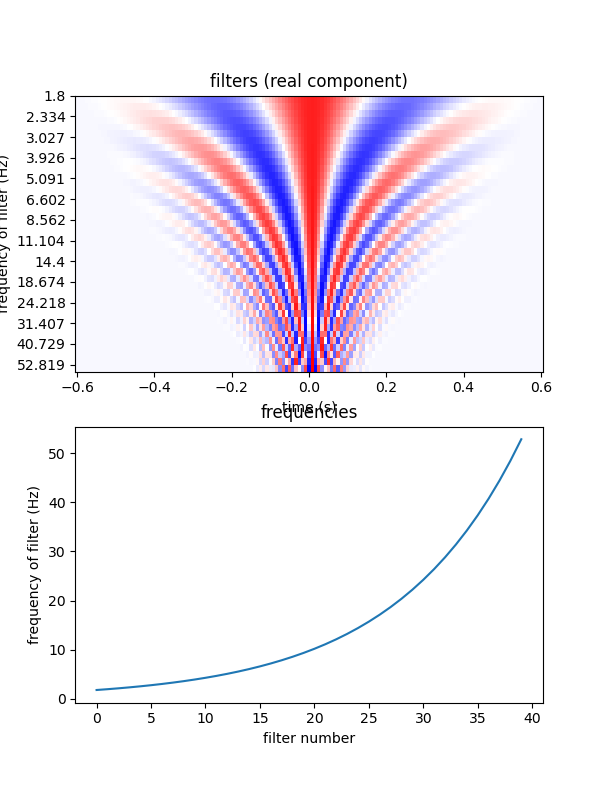

bins_per_octave: 8 bins/octave
minimum frequency (fmin): 1.9629 Hz
maximum frequency (fmax): 28.8 Hz
Nyquist                 : 60.0 Hz
number of frequencies   : 40 bins
Saving freqs_Sxx_all in Group CQT
Saving freqs_Sxx_toUse in Group CQT
Saving freq_idx_toUse in Group CQT

Estimated size of full spectrogram tensor: 10.46462 GB



<IPython.core.display.Javascript object>


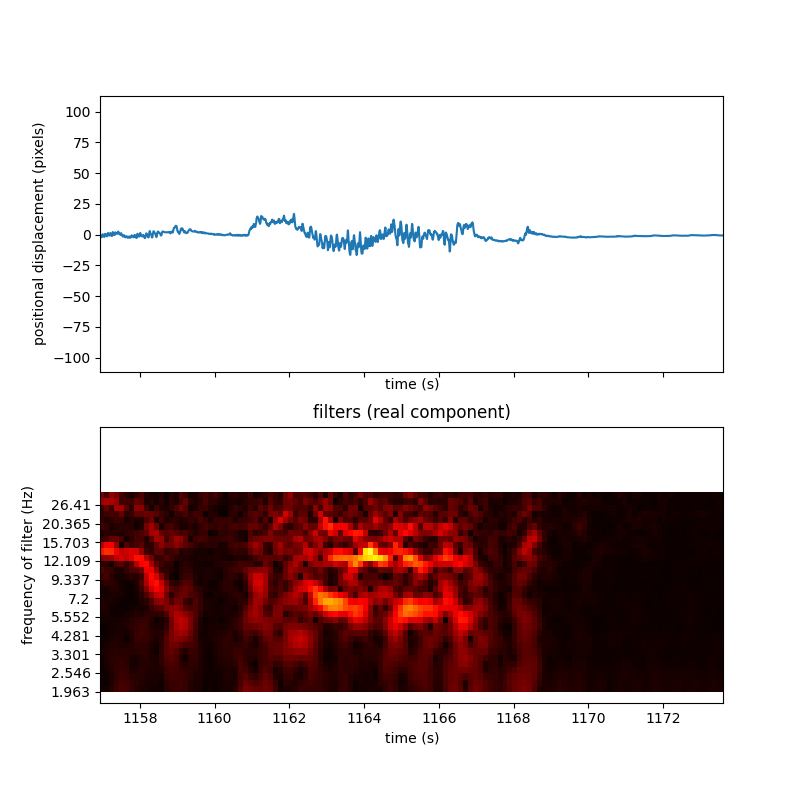

In [113]:
%matplotlib notebook

config = helpers.load_config(config_filepath)

config['CQT']['hop_length'] = 16
config['CQT']['fmin_rough'] = 1.8
config['CQT']['sampling_rate'] = config['Video']['Fs']
config['CQT']['fmax_rough'] = (config['CQT']['sampling_rate']/2)
# config['CQT']['fmax_rough'] = 30
config['CQT']['n_bins'] = 40

config['CQT']['filter_scale'] = 2
config['CQT']['gamma'] = 1.5

config['CQT']['spectrogram_exponent'] = 1
config['CQT']['normalization_factor'] = 0.97

config['CQT']['dtype_toUse'] = 'float32'

helpers.save_config(config, config_filepath)

spectral_analysis.prepare_freqs(config_filepath)

spectral_analysis.show_demo_spectrogram(config_filepath,
                        dot_toUse=1000,
                        xy_toUse='x',
                        timeSeries_toUse='positions_convDR_meanSub',
                        dtype_to_estimate=config['CQT']['dtype_toUse']
)

In [119]:
spectral_analysis.vqt_workflow(config_filepath, 
                               data_key='positions_convDR_meanSub',
                               multicore_pref=True,
                              )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
== Beginning Spectrogram Computation ==
Starting multicore pool
multicore elapsed time : 144.04 s. Now unpacking list into array.
normalizing spectrograms
completed spectrogram calculation
Info about Sxx_allPixels:

Shape: (1498, 32, 27288, 2)
Number of elements: 2616155136
Data type: float32
size of Sxx_allPixels: 0.0 GB
Spectrograms computed. Elapsed time: 2.54 minutes
Saving Sxx_allPixels in Group CQT
Saving Sxx_allPixels_norm in Group CQT
Saving Sxx_allPixels_normFactor in Group CQT
Saving Sxx_xAxis in Group CQT
Session session completed. Elapsed time: 4.9 minutes
total elapsed time. Elapsed time: 4.9 minutes
== End spectrogram computation ==


### TCA

Key TCA parameters:
- **device**: runs a small function to get your device. Set to true if you want to use the GPU. If the input is small (< half the size of your GPU memory), set to True. It's super fast.
- **rank**: ~ 2 to 10. The number of factors to look for in the PARAFAC model. More can be good but less reproduceable, but less can mix together obviously different factors
- **tolerance**: ~1e-05 to 1e-07. The minimum variance of the model between steps before declaring convergence. If you're trying to really optimize your TCA fit, try decreasing this. 
- **n_iters**: ~100 to 600. The fit of the model usually improves if you give it more iterations

In [5]:
%load_ext autoreload
%autoreload 2
from face_rhythm.analysis import tca

In [ ]:
%matplotlib notebook

config = helpers.load_config(config_filepath)
config['TCA']['pref_useGPU'] = True
config['TCA']['rank'] = 8
config['TCA']['init'] = 'random' 
config['TCA']['tolerance'] = 1e-08
config['TCA']['verbosity'] = 1
config['TCA']['n_iters'] = 1000
helpers.save_config(config, config_filepath)

tca.full_tca_workflow(config_filepath, data_key='positions_convDR_meanSub')

<IPython.core.display.Javascript object>


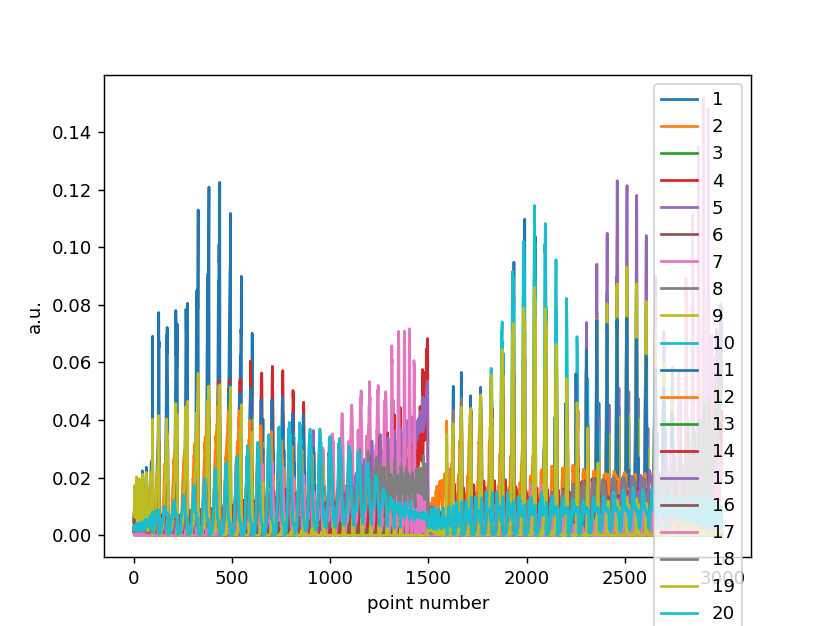

<IPython.core.display.Javascript object>


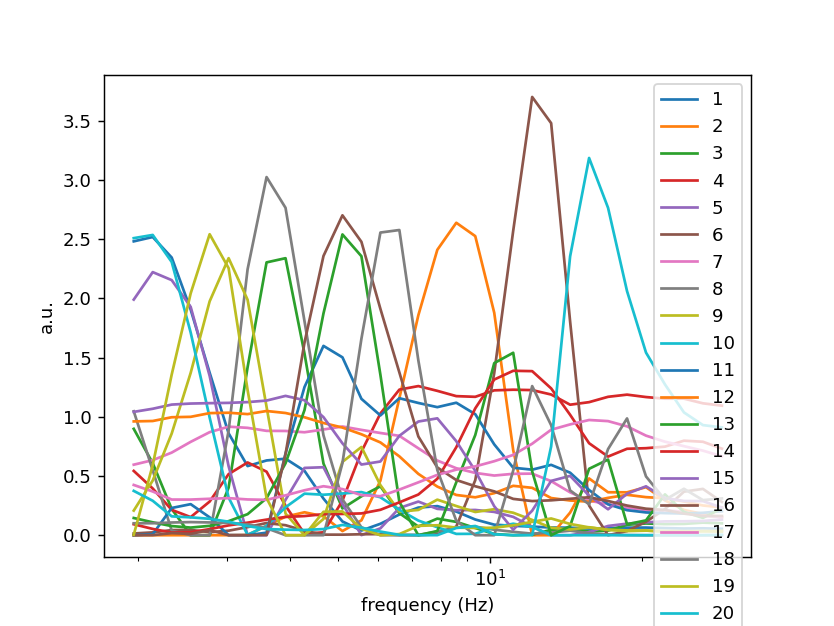

<IPython.core.display.Javascript object>


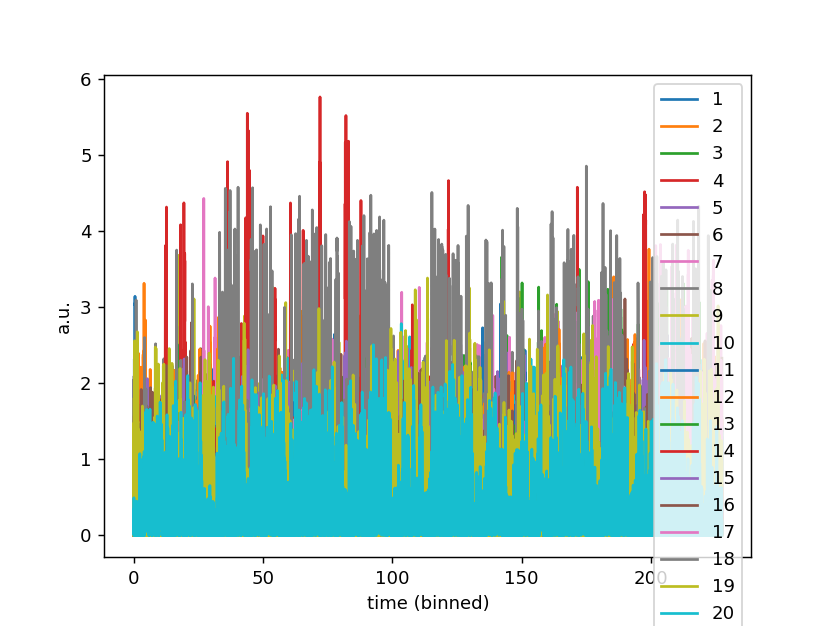

<IPython.core.display.Javascript object>


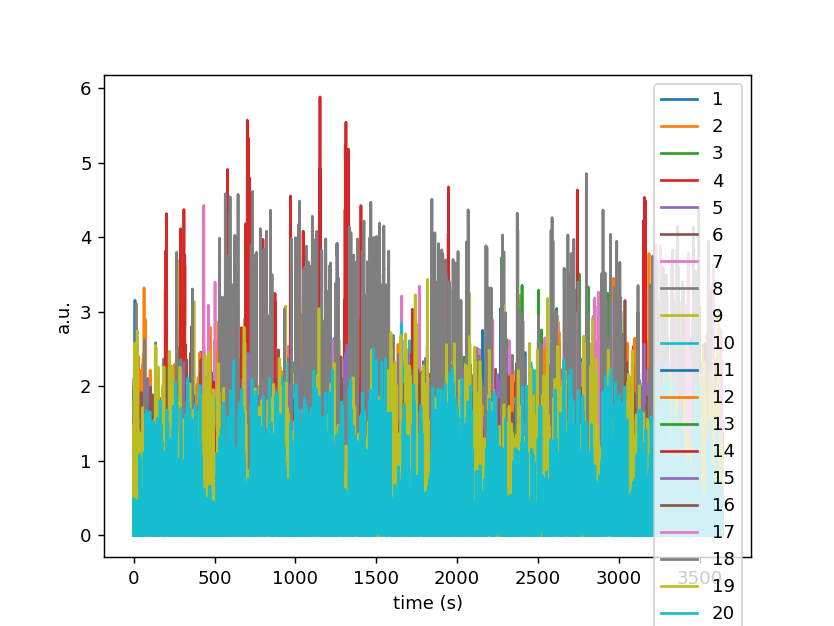

<IPython.core.display.Javascript object>


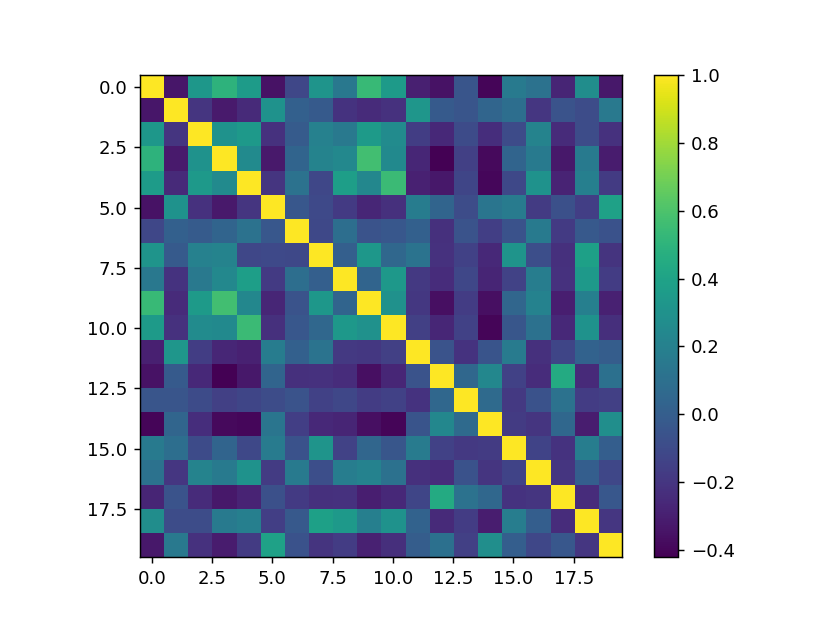

In [7]:
%matplotlib notebook
from face_rhythm.visualize import plots

config = helpers.load_config(config_filepath)
config['TCA']['ftype'] = 'spectral'
helpers.save_config(config, config_filepath)

plots.plot_tca_factors(config_filepath)

In [ ]:
from face_rhythm.visualize import videos

config = helpers.load_config(config_filepath)

config['Video']['factor_category_to_display'] = 'TCA' # eg: 'TCA' or 'PCA'
config['Video']['factor_to_display'] = 'factors_spectral_points' # eg: (if 'TCA'):'factors_frequential_points' (if 'PCA'):'scores_points'
config['Video']['points_to_display'] = 'positions_convDR_absolute' # eg: 'positions_convDR_absolute' or 'positions_absolute' or 'positions_recursive'
config['Video']['demo_len'] = 120*6
config['Video']['dot_size'] = 3
config['Video']['save_demo'] = True 
helpers.save_config(config, config_filepath)

videos.visualize_factor(config_filepath)

# END analysis

Below are some examples on how to access, plot, and manipulate the output data

## Outputs:
Below is the output tree structure of the NWB file

In [12]:
config = helpers.load_config(config_filepath)
nwb_path = config['General']['sessions'][0]['nwb']
helpers.dump_nwb(nwb_path)

CQT
     Sxx_allPixels:    (1498, 32, 27288, 2)   ,  float32   ,   10.464621 GB
     Sxx_allPixels_norm:    (1498, 32, 27288, 2)   ,  float32   ,   10.464621 GB
     Sxx_allPixels_normFactor:    (27288, 2)   ,  float32   ,   0.000218 GB
     Sxx_xAxis:    (436601,)   ,  float64   ,   0.003493 GB
     freq_idx_toUse:    (40,)   ,  bool   ,   0.0 GB
     freqs_Sxx:    (200,)   ,  float64   ,   2e-06 GB
     freqs_Sxx_all:    (40,)   ,  float64   ,   0.0 GB
     freqs_Sxx_toUse:    (32,)   ,  float64   ,   0.0 GB
Optic Flow
     color_tuples:    (253197, 3)   ,  float64   ,   0.006077 GB
     displacements:    (3960, 2, 436601)   ,  float64   ,   27.663039 GB
     pointInds_toUse:    (3960, 1, 2)   ,  float32   ,   3.2e-05 GB
     positions_cleanup:    (3960, 2, 436601)   ,  float64   ,   27.663039 GB
     positions_cleanup_absolute:    (3960, 2, 436601)   ,  float64   ,   27.663039 GB
     positions_convDR_absolute:    (1498, 2, 436601)   ,  float64   ,   10.464453 GB
     positions_conv

## Manually Change paths

## Example: How to plot factors: Spectral

<IPython.core.display.Javascript object>


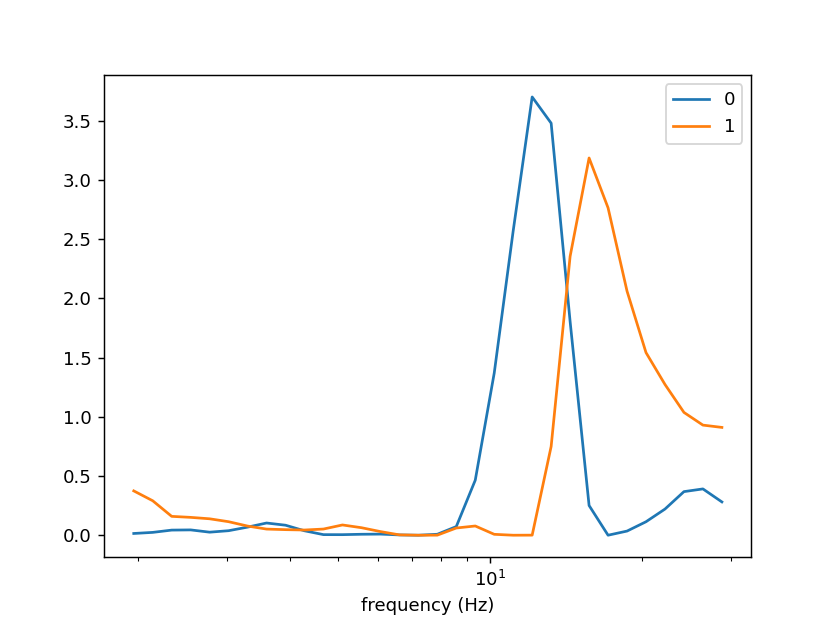

<IPython.core.display.Javascript object>


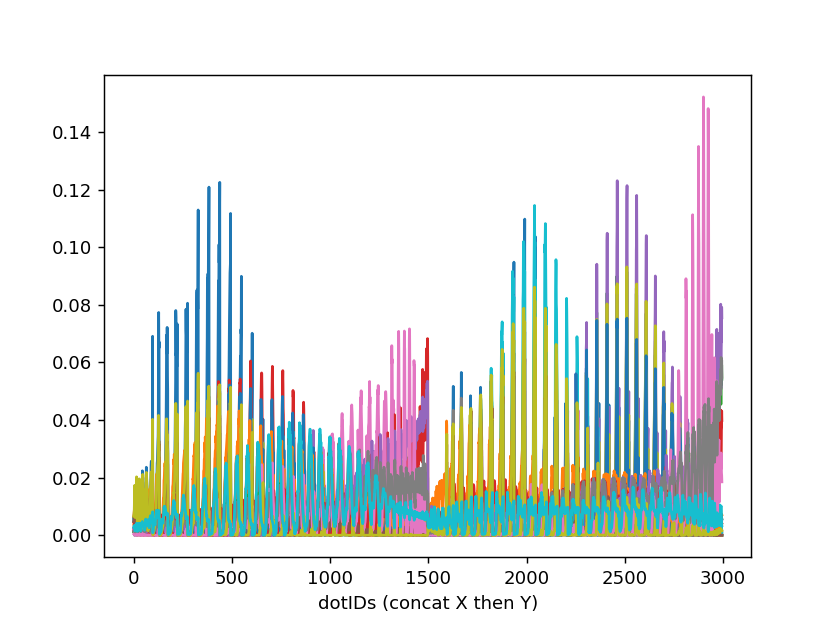

<IPython.core.display.Javascript object>


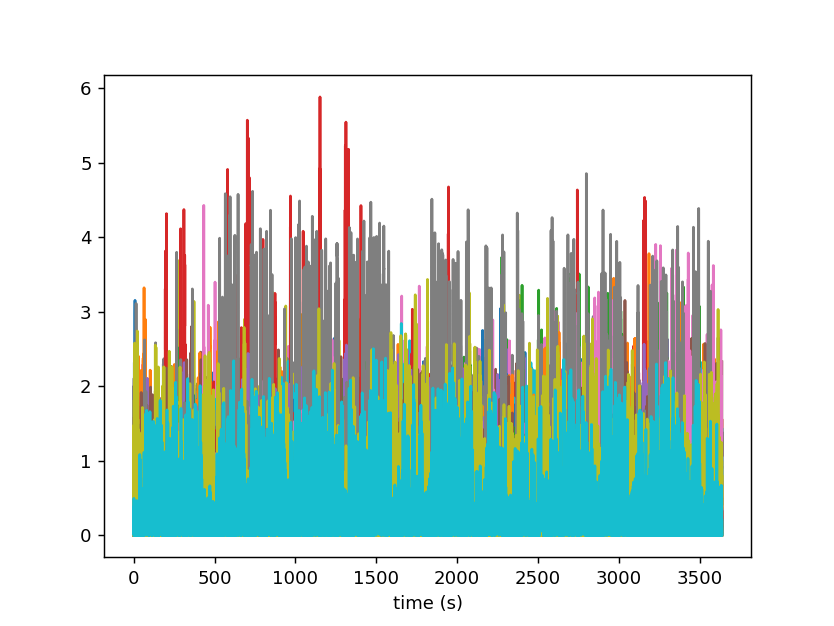

<IPython.core.display.Javascript object>


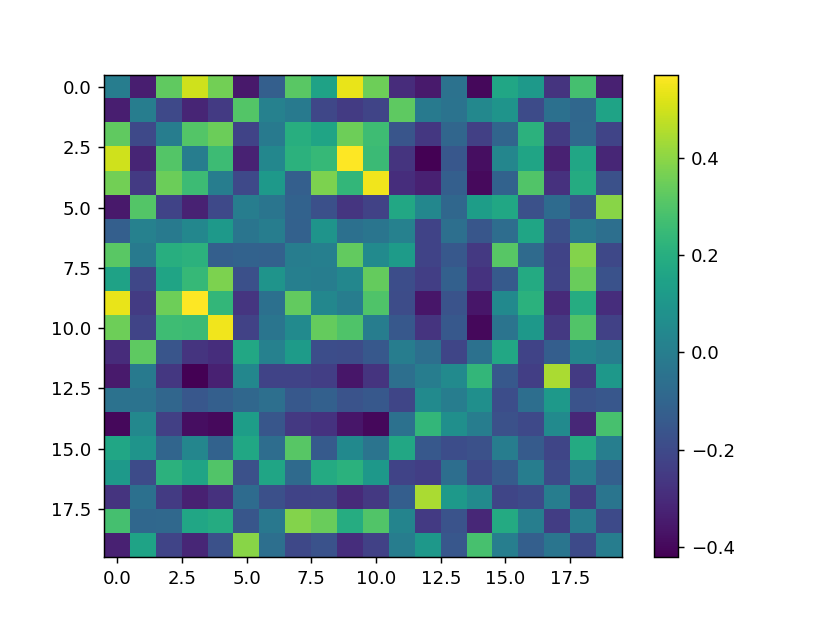

<IPython.core.display.Javascript object>


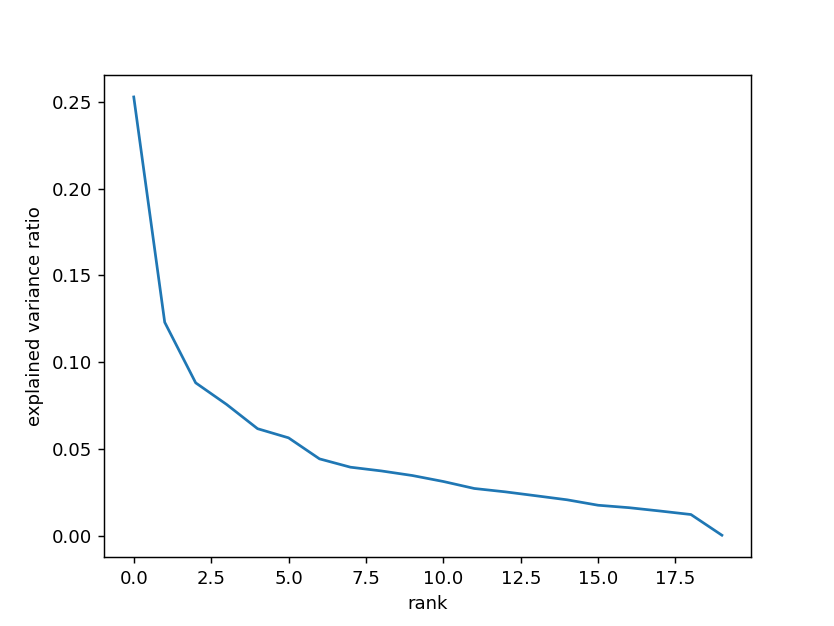

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.decomposition
import pynwb

%matplotlib notebook

config = helpers.load_config(config_filepath)
nwb_path = config['General']['sessions'][0]['nwb']

# freqs_Sxx = np.load(config['Paths']['freqs_Sxx'])
Fs = config['Video']['Fs']

with pynwb.NWBHDF5IO(nwb_path, 'r') as io:
    nwbfile = io.read()
    
    freq_components = nwbfile.processing['Face Rhythm']['TCA']['factors_spectral_spectral'].data
    dot_components = nwbfile.processing['Face Rhythm']['TCA']['factors_spectral_points'].data
    temp_components_interp = nwbfile.processing['Face Rhythm']['TCA']['factors_spectral_temporal_interp'].data
    
    freqs_Sxx = nwbfile.processing['Face Rhythm']['CQT']['freqs_Sxx_toUse'].data
    
    num_factors = freq_components.shape[1]

    plt.figure()
    plt.plot(freqs_Sxx , freq_components[:,:])
#     plt.plot(freq_components[:,:])
    plt.xscale('log')
    plt.xlabel('frequency (Hz)')
    plt.legend(np.arange(num_factors))
    
    plt.figure()
    plt.plot(dot_components[:,:])
    plt.xlabel('dotIDs (concat X then Y)')
    
    plt.figure()
    plt.plot(np.arange(temp_components_interp.shape[0])/Fs , temp_components_interp[:,:])
    plt.xlabel('time (s)')
    
    plt.figure()
    plt.imshow(np.corrcoef(np.array(temp_components_interp).T) - np.eye(num_factors),aspect='auto')
    plt.colorbar()
    
    pca = sklearn.decomposition.PCA(n_components=num_factors)
    pca.fit(temp_components_interp)
#     PCA(n_components=8)
    plt.figure()
    plt.plot(pca.explained_variance_ratio_)
    plt.xlabel('rank')
    plt.ylabel('explained variance ratio')

## Example: How to plot factors: Positional

In [18]:
import sklearn as sk
import sklearn.decomposition
import pynwb
import numpy as np

%matplotlib notebook

config = helpers.load_config(config_filepath)
nwb_path = config['General']['sessions'][0]['nwb']

Fs = config['Video']['Fs']

with pynwb.NWBHDF5IO(nwb_path, 'r') as io:
    nwbfile = io.read()
    
#     dot_components = np.array(nwbfile.processing['Face Rhythm']['TCA']['factors_positional_points'].data)
    temp_components = np.array(nwbfile.processing['Face Rhythm']['TCA']['factors_spectral_temporal_interp'].data)
    np.save('/media/rich/bigSSD RH/analysis_data/mouse 2_6/20210417/FR_run1/data/factors_spectral_temporal_interp.npy' , temp_components)
    
#     plt.figure()
#     plt.plot(freqs_Sxx , freq_components[:,:])
#     plt.xscale('log')
#     plt.xlabel('frequency (Hz)')
    
    plt.figure()
    plt.plot(dot_components[:,:])
    plt.xlabel('dotIDs (concat X then Y)')
    
    plt.figure()
    plt.plot(np.arange(temp_components.shape[0])/Fs , temp_components[:,:])
    plt.xlabel('time (s)')
    
    plt.figure()
    plt.imshow(np.corrcoef(np.array(temp_components).T) - np.eye(4),aspect='auto')
    plt.colorbar()

<IPython.core.display.Javascript object>

ValueError: Not a dataset (not a dataset)

## Example: How to access NWB output data

In [ ]:
import pynwb
import matplotlib.pyplot as plt
import numpy as np

config = helpers.load_config(config_filepath)
nwb_path = config['General']['sessions'][0]['nwb']
with pynwb.NWBHDF5IO(nwb_path, 'r') as io:
    nwbfile = io.read()
    
    # look through the NWB outputs (see above example) to see available arrays to plot and how to access them
    example_data = nwbfile.processing['Face Rhythm']['Optic Flow']['positions_convDR_meanSub'].data
    print(example_data)
    plt.figure()
    plt.plot(example_data[0,0,:])

## Example: How save NWB data as other format (.npy)

In [9]:
import pynwb
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

save_dir = Path(r'/media/rich/bigSSD/analysis_data/mouse 2_6/20210417/FR_run1_vqt/data')
save_name = r'factors_spectral_temporal_interp'
save_fileSuffix = '.npy'

save_path = save_dir / (save_name + save_fileSuffix)

config = helpers.load_config(config_filepath)
nwb_path = config['General']['sessions'][0]['nwb']
with pynwb.NWBHDF5IO(nwb_path, 'r') as io:
    nwbfile = io.read()
    
    # look through the NWB outputs (see above example) to see available arrays to plot and how to access them
    example_data = nwbfile.processing['Face Rhythm']['TCA']['factors_spectral_temporal_interp'].data
    
    np.save(save_path , example_data)
    

## Example of how to access parameters

In [ ]:
config = helpers.load_config(config_filepath)
print(config['Optic']['lk']['winSize'])